### Step 3

# Create geological model

#### Import Python libraries

In [104]:
import sys, warnings
warnings.filterwarnings('ignore')
sys.path.append("../../gempy")

import numpy as np
import gempy as gp # importing gempy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline

### Step 3b: Define geological model object, load the interface and foliation data files and set model extent

In [105]:
geo_data=gp.create_data(extent=[612000, 622000, 2472000, 2480000, -1000, 1000], 
                        resolution=[50, 50, 50],
                        path_f = "../data/gempy_foliations.csv",
                        path_i = "../data/gempy_interfaces.csv")

### Step 3c: Set stratigraphic order

<div class="alert alert-info">
**Your task:** Enter the correct ordering of formation names as strings in the list variable *order_formations* in the code cell below and execute the following code cell to set the stratigraphic order for the modeling software.
</div>

<div class="alert alert-warning">
**Note**: you can keep the provided names, or adjust them to suit your own definitions
</div>



In [106]:
order_formations = ["Unit4", "Unit3", "Unit2", "Unit1"]

With the code in the next cell, we define the order of the geological formations and obtain an overview of the stratigraphic pile.

<div class="alert alert-warning">
**Note**: We only have one modeling "series" in this case. A series (in this modeling context) is defined as a sequence of (sub-)parallel surfaces. However, the order of the "Units" is important and should reflect the actual relative age ordering you interpret from GoogleEarth.
</div>




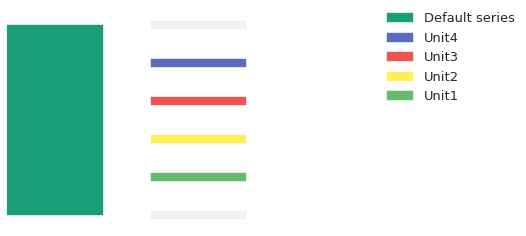

In [107]:
gp.set_series(geo_data, {"Default series": order_formations},
             order_formations = order_formations)


### Step 3d: create plots of raw data in map view and cross sections

<div class="alert alert-info">
**Your task:** Execute the code below to generate a plot of your picked points and processed orientation values. Note: adjust `direction="z"` to `direction="x"` or `direction="y"` to get section views in E-W and N-S directions:
</div>

<div class="alert alert-warning">
**Note**: review carefully at this step if the defined sequence order in the stratigraphic pile is correct!
</div>



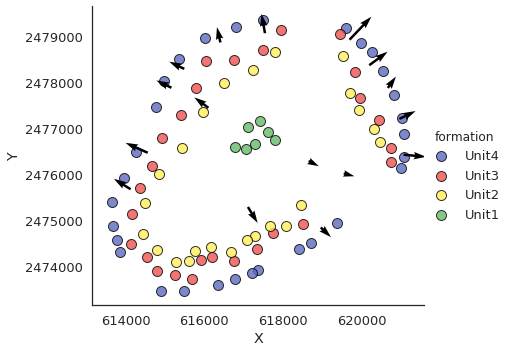

In [108]:
gp.plot_data(geo_data, direction="z")

### Step 3e (optional): visualize input data in 3-D using VTK

<div class="alert alert-info">
**Your task:** Execute the code below to generate a 3-D visualisation in an external VTK-viewer:
</div>


<div class="alert alert-danger">
**Important note**: 3D-Visualization using VTK is not available if you use Docker to run this exercise. This part is **optional**.
</div>

In [7]:
gp.plot_data_3D(geo_data)

NameError: name 'vtk' is not defined

#### Computing the 3D Model

<div class="alert alert-info">
**Your task:** Execute the following cells to perform the model interpolation step:
</div>

<div class="alert alert-warning">
**Note**: The following code cell will need several minutes to execute, depending on your system configuration. As this step is compute- and memory-intense, it can also fail (you will then get a "kernal died" warning). If this happens, then check your memory settings (especially if you are using the installtion in a docker container) and re-run the notebook.
</div>

In [109]:
interp_data = gp.InterpolatorInput(geo_data, dtype="float32", u_grade=[3])

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32


In [110]:
lith_block, fault_block = gp.compute_model(interp_data)
print("3-D geological model calculated.")

3-D geological model calculated.


### Step 4

## Post-processing results for visualization and interpretation

#### 2D Sections

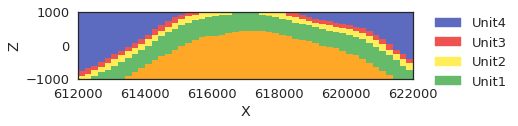

In [111]:
gp.plot_section(geo_data, lith_block[0], 25, direction='y', plot_data=False)

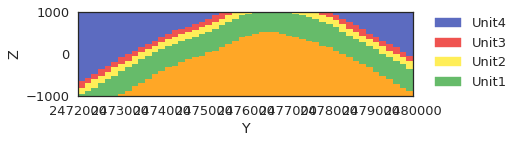

In [112]:
gp.plot_section(geo_data, lith_block[0], 25, direction='x', plot_data=False)

#### Pseudo-3D surfaces

In [12]:
v_l, s_l = gp.get_surfaces(interp_data, potential_lith=lith_block[1], step_size=2)

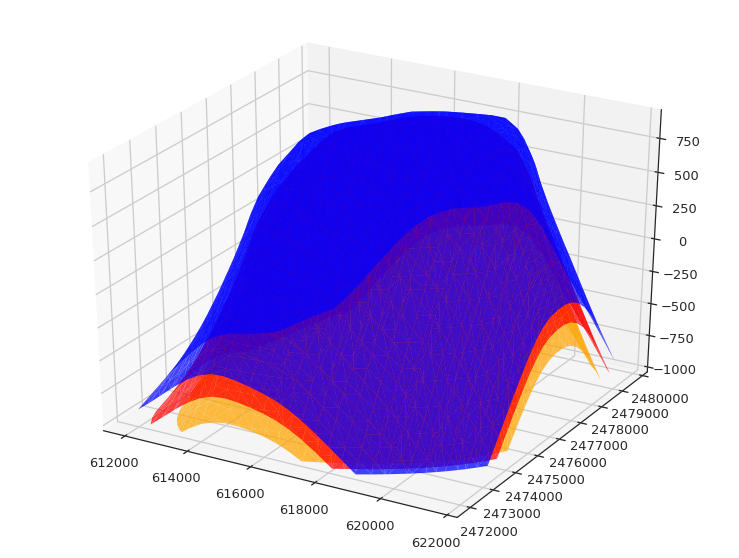

In [13]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')

cs = ["blue", "red", "orange"]



for i in range(3):
    surf = ax.plot_trisurf(v_l[i][:,0], v_l[i][:,1], v_l[i][:,2], 
                           color=cs[i], linewidth=0, alpha=0.75, shade=False)

#### 3D Visualization using VTK

<div class="alert alert-danger">
**Important note**: 3D-Visualization using VTK is not available if you use Docker to run this exercise. This part is **optional**.
</div>

In [14]:
gp.plot_surfaces_3D(geo_data, v_l, s_l)

NameError: name 'vtk' is not defined

#### Exporting a geological map

In [15]:
import gdal
geotiff_filepath = "../data/dome_sub_sub_utm.tif"
raster = gdal.Open(geotiff_filepath)
dtm = raster.ReadAsArray()

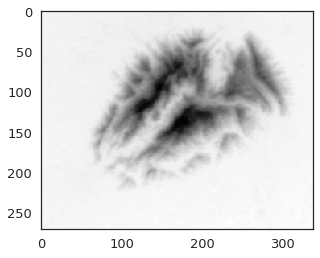

In [16]:
import matplotlib.pyplot as plt
plt.imshow(dtm, origin='upper')
plt.show()

In [17]:
dtm.shape

(271, 339)

In [18]:
# here are the raster dimensions:
raster.RasterXSize, raster.RasterYSize
geoinformation = raster.GetGeoTransform()

In [19]:
geoinformation

(612000.0, 29.49852507374631, 0.0, 2480000.0, 0.0, -29.52029520295203)

get DTM corners:


In [20]:
dtm_E_min = geoinformation[0]
dtm_E_max = geoinformation[0] + geoinformation[1] * raster.RasterXSize
dtm_N_min = geoinformation[3] + geoinformation[5] * raster.RasterYSize
dtm_N_max = geoinformation[3]
dtm_E_min, dtm_E_max, dtm_N_min, dtm_N_max

(612000.0, 622000.0, 2472000.0, 2480000.0)

In [21]:
# define range for x, y - values
X_range = np.arange(dtm_E_min, dtm_E_max, geoinformation[1])
Y_range = np.arange(dtm_N_min, dtm_N_max, np.abs(geoinformation[5]))
XX, YY = np.meshgrid(X_range, Y_range, indexing="ij")

Create list of input points for interpolation with gempy:

In [22]:
points = np.array(list(zip(XX.ravel(), YY.ravel(), dtm[::-1,:].T.ravel())))

Build basic gempy using _data_ extent (_resolution_ does not matter  for the interpolation but yes for the visualization):

In [23]:
geo_data=gp.create_data(extent=[612000, 622000, 2472000, 2480000, -1000, 1000],  
                        resolution=[339,271,1], 
                        path_f = "../data/gempy_foliations.csv",
                        path_i = "../data/gempy_interfaces.csv")

gp.set_series(geo_data, {"Default series": np.unique(geo_data.interfaces["formation"].values)},
             order_formations = order_formations, verbose=0)

Now here the "trick": replace grid points with DTM grid points:

In [24]:
geo_data.grid.grid = points

Perform the "usual" interpolation step:

In [114]:
interp_data = gp.InterpolatorInput(geo_data, dtype="float64")
lith_block, fault_block = gp.compute_model(interp_data)

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64


And here: **the geological map**:

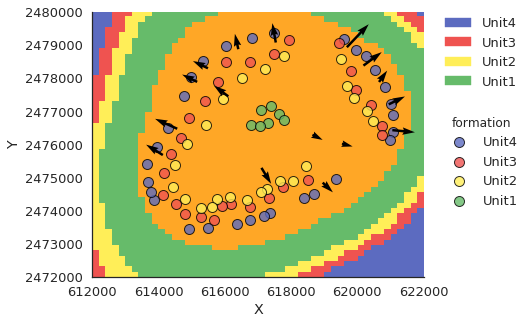

In [115]:
gp.plot_section(geo_data,lith_block[0], 0, direction='z', plot_data=True)

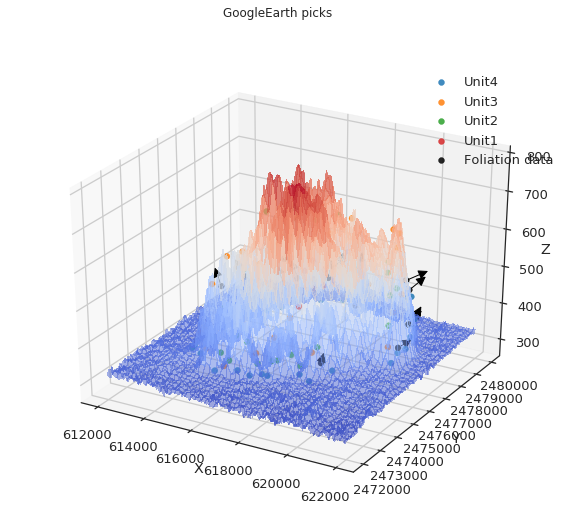

In [32]:
sys.path.append(r"..")  # append local path to access rgeomod module
import rgeomod
from matplotlib import cm
# **********************************************************************
interfaces = geo_data.interfaces
foliations = geo_data.foliations
# %matplotlib qt5
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')


ax.plot_surface(XX, YY, dtm[::-1, :].T,  cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.5)    
    

# **********************************************************************
for fmt in interfaces["formation"].unique():  # loop over all unique formations
    interf = interfaces[interfaces["formation"] == fmt]  # select only current formation
    ax.scatter(interf["X"], interf["Y"], interf["Z"], alpha=0.85, s=35, label=fmt)  # plot points of current formation

# plot foliation data
ax.scatter(foliations["X"], foliations["Y"], foliations["Z"], color="black", alpha=0.85, s=35, label="Foliation data")

rgeomod.calculate_gradient(foliations)

# **********************************************************************
# The following code will add arrows to indicate the foliation values
# **********************************************************************

# get extent of plot to adjust vectors:
ext_x, ext_y, ext_z = np.diff(ax.get_xlim3d()), np.diff(ax.get_ylim3d()), np.diff(ax.get_zlim3d())
m = 1000

# plot and arrow for each foliation value in the DataFrame
for i, row in foliations.iterrows():
    a = rgeomod.Arrow3D([row["X"], row["X"]+row["G_x"]*m],
                        [row["Y"], row["Y"]+row["G_y"]*m*ext_y/ext_x],
                        [row["Z"], row["Z"]+row["G_z"]*m*ext_z/ext_x],  mutation_scale=20,
                        lw=1, arrowstyle="-|>", color="k"
                       )
    ax.add_artist(a)  # add the arrow artist to the subplot axes

# **********************************************************************
# add plot legend and  labels
ax.legend()  
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
fig.suptitle("GoogleEarth picks");

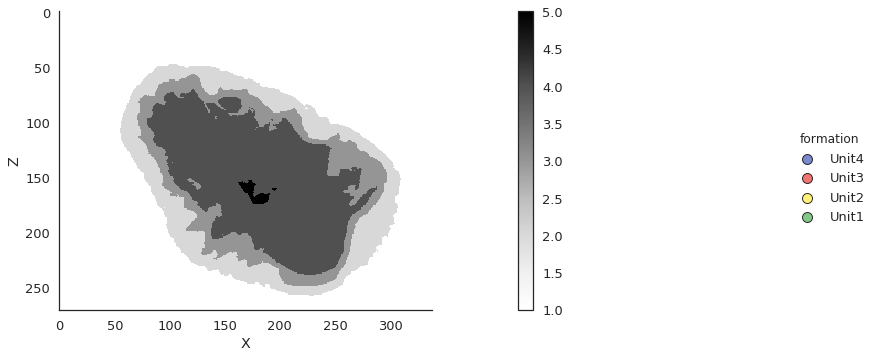

In [82]:
geo_map = lith_block[0].copy().reshape((339,271))
# adjust scale
# geo_map += 1
# adjust misfits:
geo_map[np.where(geo_map==0)] = 5
# geo_map[np.where(geo_map==6)] = 2
# geo_map[np.where(geo_map==7)] = 3
# geo_map[np.where(geo_map==8)] = 4
# geo_map[np.where(geo_map==1)] = 5
# geo_map -= 1
# change to int for later use:
geo_map = geo_map.astype('int16')
# adjust orientation:
#geo_map = geo_map[::-1,:]
gp.plot_data(geo_data)
plt.imshow(geo_map.T)#, cmap=gp.colors.cmap, norm=gp.colors.norm, origin='up')

plt.colorbar()

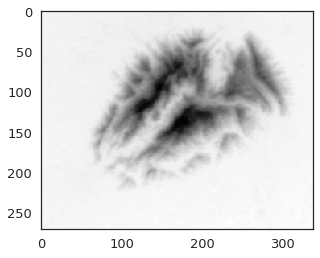

In [73]:
import matplotlib.pyplot as plt
plt.imshow(dtm)
plt.show()

In [74]:
np.min(dtm), np.max(dtm)

(289, 781)

In [85]:
# set number of layers for correct coloring:
n = 5

file = geotiff_filepath
outFileName = "/data/geomap.tif"
# transform data
# geo_map = geo_map.astype('int16')
ds = gdal.Open(file)
band = ds.GetRasterBand(1)
arr = band.ReadAsArray()
[cols, rows] = arr.shape
# arr_min = arr.min()
# arr_max = arr.max()
# arr_mean = int(arr.mean())
# arr_out = np.where((arr < arr_mean), 10000, arr)
driver = gdal.GetDriverByName("GTiff")
# options = ['PHOTOMETRIC=RGB', 'PROFILE=GeoTIFF']
options = ['PROFILE=GeoTiff', 'PHOTOMETRIC=RGB', 'COMPRESS=JPEG']
# outdata = driver.Create(outFileName, rows, cols, 3, gdal.GDT_UInt16, options=options)
outdata = driver.Create(outFileName, rows, cols, 3, gdal.GDT_Byte, options=options)


outdata.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(geo_map[:,::-1].T*256/n)
outdata.GetRasterBand(2).WriteArray(geo_map[:,::-1].T*256/n)
outdata.GetRasterBand(3).WriteArray(geo_map[:,::-1].T*256/n)
# outdata.GetRasterBand(4).WriteArray(np.ones_like(geo_map)*100)
outdata.GetRasterBand(1).SetColorInterpretation(gdal.GCI_RedBand)
outdata.GetRasterBand(2).SetColorInterpretation(gdal.GCI_GreenBand)
outdata.GetRasterBand(3).SetColorInterpretation(gdal.GCI_BlueBand)
# outdata.GetRasterBand(4).SetColorInterpretation(gdal.GCI_AlphaBand)


# outdata.GetRasterBand(1).SetNoDataValue(999)##if you want these values transparent
outdata.FlushCache() ##saves to disk!!
outdata = None
band=None
ds=None

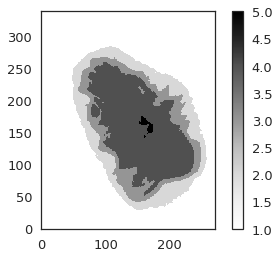

In [84]:
plt.imshow(geo_map[::-1,:], origin='lower left')
geo_map[np.where(geo_map == 0)] = 10
plt.colorbar()
plt.show()

In [ ]:
arr.dtype

In [ ]:
geo_map.dtype

In [33]:
ds = gdal.Open(file)

In [34]:
ds.GetRasterBand

<bound method Dataset.GetRasterBand of <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f0819b6bbd0> >>

In [35]:
np.min(geo_map), np.max(geo_map*64)

(1, 256)

In [36]:
geo_map.shape

(339, 271)

In [37]:
ds = gdal.Open(file)
band = ds.GetRasterBand(1)
arr = band.ReadAsArray()

In [38]:
arr.shape

(271, 339)